---
title: 'DANL 320 | Linear Regression w/ PySpark'
toc: True
---

# Importing Modules & Reading
___

In [3]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, pow, mean, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
spark = SparkSession.builder.master("local[*]").getOrCreate()

# 1. Read CSV data from URL
df_pd = pd.read_csv('https://bcdanl.github.io/data/home_sales_nyc.csv')
sale_df = spark.createDataFrame(df_pd)
sale_df.show()

+---------+-------+------------+--------------------+-----------------------+--------+----------+-----------------+----------------+-----------+----------------+-----------------+----------+---------+---+
|sale.date|borough|borough_name|        neighborhood|building_class_category|zip_code|sale_price|residential_units|commercial_units|total_units|land_square_feet|gross_square_feet|year_built|sale_year|age|
+---------+-------+------------+--------------------+-----------------------+--------+----------+-----------------+----------------+-----------+----------------+-----------------+----------+---------+---+
|  8/31/18|      2|       Bronx|CASTLE HILL/UNION...|   01 ONE FAMILY DWE...|   10473|    492525|                1|               0|          1|            2250|             1540|      1960|     2018| 58|
|  8/31/18|      2|       Bronx|           SOUNDVIEW|   01 ONE FAMILY DWE...|   10473|    105000|                1|               0|          1|            3980|             1025| 

# Univariate Linear Regression w/ PySpark
___

## Splitting Data into Train and Test Sets

In [ ]:
# 2. Split data into training and testing sets by creating a random column "gp"
sale_df = sale_df.withColumn("gp", rand(seed=123)) # seed is set for replication

# Splits 60-40 into training and test sets
dtrain = sale_df.filter(col("gp") >= 0.4)
dtest = sale_df.filter(col("gp") < 0.4)

# Or simply,
dtrain, dtest = sale_df.randomSplit([0.6, 0.4], seed = 123)

## Building ML DF Using `VectorAssembler()`

* VectorAssembler
  - Transformer in Pyspark ML Library
  - Used to combine multiple cols into single vector col
  - Many ML Algs in spark req predictors to be represented as a single vector
  - VectorAssembler often one of 1st steps in SparkML Pipeline


* `VectorAssembler.transform()` returns DF with new col, specified in ***outputCol*** arg in VectorAssembler

In [ ]:
# Now assemble predictors using the renamed column
assembler1 = VectorAssembler(
    inputCols=["gross_square_feet"],
    outputCol="predictors")

dtrain1 = assembler1.transform(dtrain) # training data
dtest1  = assembler1.transform(dtest)  # test data

print('Training Set')
dtrain1.select("predictors", "sale_price").show()

print('Test Set')
dtest1.select("predictors", "sale_price").show()

Training Set
+----------+----------+
|predictors|sale_price|
+----------+----------+
|  [1742.0]|    349830|
|  [2165.0]|    570000|
|  [1116.0]|    410000|
|  [1120.0]|    260000|
|  [2304.0]|    543556|
|  [1830.0]|    610000|
|  [4200.0]|   1650000|
|  [1446.0]|    905000|
|  [1445.0]|   1150000|
|   [978.0]|    850000|
|  [1444.0]|    980000|
|  [1510.0]|   1130000|
|  [1428.0]|    425000|
|  [1712.0]|    860000|
|  [1200.0]|   1020000|
|  [2363.0]|   1200000|
|  [1197.0]|    427000|
|  [1080.0]|    423000|
|  [1392.0]|    325000|
|  [1400.0]|    597000|
+----------+----------+
only showing top 20 rows

Test Set
+----------+----------+
|predictors|sale_price|
+----------+----------+
|  [1080.0]|    495000|
|  [2320.0]|    575000|
|  [2844.0]|   1700000|
|  [1696.0]|    650000|
|  [2000.0]|   1350000|
|  [2300.0]|   1500000|
|  [1314.0]|    940000|
|  [2452.0]|    550000|
|  [1125.0]|    820000|
|  [1690.0]|    235000|
|  [2163.0]|    695000|
|  [1870.0]|    590000|
|  [2052.0]|    

## Building Lin Reg Model using `LinearRegression().fit()`

* LinearRegression(featuresCol = 'predictors', labelCol = 'sale_price')
  - Creates instance of Linear Regression class
  - features are in a col named `predictors`
  - label is in a column named `sale_price`

* .fit() trains lin reg model using training DF `dtrain1`
  - this process est beta coef. that best predict label from features

In [ ]:
# Fit linear regression model using the new label column "sale_price"
model1 = (
    LinearRegression(
        featuresCol = "predictors",
        labelCol = "sale_price")
    .fit(dtrain1)
)

## Summary of Regression Result

In [ ]:
items= [model1.intercept,
model1.coefficients,
model1.summary.coefficientStandardErrors,
model1.summary.rootMeanSquaredError,
model1.summary.r2]

for i in items:
  print(i)

-28248.33125480523
[456.5835962723607]
[9.1585344019424, 14842.026122561703]
459852.1900902878
0.24763531485957802


### Making Summary Look Better

In [ ]:
import numpy as np
import scipy.stats as stats
from tabulate import tabulate

def regression_table(model, assembler):
    """
    Creates a formatted regression table from a fitted LinearRegression model and its VectorAssembler,
    and inserts a dashed horizontal line after the Intercept row. The table includes separate columns
    for the 95% confidence interval lower and upper bounds for each coefficient (computed at the 5% significance level)
    and an "Observations" row (using model.summary.numInstances) above the R² row.
    The RMSE row is placed as the last row.

    The columns are ordered as:
        Metric | Value | Significance | Std. Error | p-value | 95% CI Lower | 95% CI Upper

    For the "Value", "Std. Error", "95% CI Lower", and "95% CI Upper" columns, commas are inserted every three digits,
    with 3 decimal places (except for Observations which is formatted as an integer with commas).

    Parameters:
        model: A fitted LinearRegression model (with a .summary attribute).
        assembler: The VectorAssembler used to assemble the features for the model.

    Returns:
        A formatted string containing the regression table.
    """
    # Extract coefficients and standard errors as NumPy arrays
    coeffs = model.coefficients.toArray()
    std_errors_all = np.array(model.summary.coefficientStandardErrors)

    # Check if the intercept's standard error is included (one extra element)
    if len(std_errors_all) == len(coeffs) + 1:
        intercept_se = std_errors_all[0]
        std_errors = std_errors_all[1:]
    else:
        intercept_se = None
        std_errors = std_errors_all

    # Compute t-statistics for feature coefficients (t = beta / SE(beta))
    # t_stats = coeffs / std_errors
    t_stats = model.summary.tValues

    # Degrees of freedom: number of instances minus number of predictors minus 1 (for intercept)
    df = model.summary.numInstances - len(coeffs) - 1

    # Compute the t-critical value for a 95% confidence interval (two-tailed, 5% significance)
    t_critical = stats.t.ppf(0.975, df)

    # Compute two-tailed p-values for each feature coefficient
    # p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_stats]
    p_values = model.summary.pValues

    # Function to assign significance stars based on p-value
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Build the table rows.
    # Order: Metric, Value, Significance, Std. Error, p-value, 95% CI Lower, 95% CI Upper.
    table = []
    for feature, beta, se, p in zip(assembler.getInputCols(), coeffs, std_errors, p_values):
        ci_lower = beta - t_critical * se
        ci_upper = beta + t_critical * se
        table.append([
            "Beta: " + feature,       # Metric name
            beta,                     # Beta estimate (Value)
            significance_stars(p),    # Significance stars
            se,                       # Standard error
            p,                        # p-value
            ci_lower,                 # 95% CI lower bound
            ci_upper                  # 95% CI upper bound
        ])

    # Compute and add the intercept row with its SE, p-value, significance, and CI (if available)
    if intercept_se is not None:
        intercept_t = model.intercept / intercept_se
        intercept_p = 2 * (1 - stats.t.cdf(np.abs(intercept_t), df))
        intercept_sig = significance_stars(intercept_p)
        ci_intercept_lower = model.intercept - t_critical * intercept_se
        ci_intercept_upper = model.intercept + t_critical * intercept_se
    else:
        intercept_se = ""
        intercept_p = ""
        intercept_sig = ""
        ci_intercept_lower = ""
        ci_intercept_upper = ""

    table.append([
        "Intercept",
        model.intercept,
        intercept_sig,
        intercept_se,
        intercept_p,
        ci_intercept_lower,
        ci_intercept_upper
    ])

    # Append overall model metrics:
    # Insert an Observations row using model.summary.numInstances,
    # then an R² row, and finally the RMSE row as the last row.
    table.append(["Observations", model.summary.numInstances, "", "", "", "", ""])
    table.append(["R²", model.summary.r2, "", "", "", "", ""])
    table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", ""])

    # Format the table.
    # For the "Value" (index 1), "Std. Error" (index 3), "95% CI Lower" (index 5), and "95% CI Upper" (index 6) columns,
    # format with commas and 3 decimal places, except for Observations which should be an integer with commas.
    # For the p-value (index 4), format to 3 decimal places.
    formatted_table = []
    for row in table:
        formatted_row = []
        for i, item in enumerate(row):
            if row[0] == "Observations" and i == 1 and isinstance(item, (int, float, np.floating)) and item != "":
                # Format Observations as integer with commas, no decimals.
                formatted_row.append(f"{int(item):,}")
            elif isinstance(item, (int, float, np.floating)) and item != "":
                if i in [1, 3, 5, 6]:
                    formatted_row.append(f"{item:,.3f}")
                elif i == 4:
                    formatted_row.append(f"{item:.3f}")
                else:
                    formatted_row.append(f"{item:.3f}")
            else:
                formatted_row.append(item)
        formatted_table.append(formatted_row)

    # Generate the table string using tabulate.
    table_str = tabulate(
        formatted_table,
        headers=["Metric", "Value", "Sig.", "Std. Error", "p-value", "95% CI Lower", "95% CI Upper"],
        tablefmt="pretty",
        colalign=("left", "right", "center", "right", "right", "right", "right")
    )

    # Insert a dashed line after the Intercept row for clarity.
    lines = table_str.split("\n")
    dash_line = '-' * len(lines[0])
    for i, line in enumerate(lines):
        if "Intercept" in line and not line.strip().startswith('+'):
            lines.insert(i+1, dash_line)
            break

    return "\n".join(lines)

# Example usage:
# print(regression_table(lr_model, assembler))

In [ ]:
print(regression_table(model1, assembler1))

+-------------------------+-------------+------+------------+---------+--------------+--------------+
| Metric                  |       Value | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+-------------------------+-------------+------+------------+---------+--------------+--------------+
| Beta: gross_square_feet |     456.584 | ***  | 14,842.026 |   0.000 |  -28,637.917 |   29,551.084 |
| Intercept               | -28,248.331 | ***  |      9.159 |   0.000 |  -28,266.285 |  -28,230.378 |
-----------------------------------------------------------------------------------------------------
| Observations            |       7,553 |      |            |         |              |              |
| R²                      |       0.248 |      |            |         |              |              |
| RMSE                    | 459,852.190 |      |            |         |              |              |
+-------------------------+-------------+------+------------+---------+-----------

# Multivariate Linear Regression w/ PySpark
___

## Adding new predictor `age` to VectorAssembler()

In [ ]:
assembler2 = VectorAssembler(
                    inputCols=["gross_square_feet", "age"],
                    outputCol="predictors")
dtrain2 = assembler2.transform(dtrain)
dtest2  = assembler2.transform(dtest)

model2 = LinearRegression(
                featuresCol="predictors",
                labelCol="sale_price").fit(dtrain2)
dtest2 = model2.transform(dtest2)

print(regression_table(model2, assembler2))

+-------------------------+--------------+------+------------+---------+--------------+--------------+
| Metric                  |        Value | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+-------------------------+--------------+------+------------+---------+--------------+--------------+
| Beta: gross_square_feet |      463.107 | ***  |    192.136 |   0.000 |       86.467 |      839.748 |
| Beta: age               |    2,429.358 | ***  | 20,938.514 |   0.000 |  -38,615.955 |   43,474.670 |
| Intercept               | -216,925.023 | ***  |      9.078 |   0.000 | -216,942.819 | -216,907.227 |
------------------------------------------------------------------------------------------------------
| Observations            |        7,553 |      |            |         |              |              |
| R²                      |        0.263 |      |            |         |              |              |
| RMSE                    |  455,059.540 |      |            |         | 

# Residuals
___

- Residual Error is essentially the estimate of the error term (random noise) in lin reg expression.

- residual error is found by Yi - Y_hati
 - or actual - predicted

## Residual Plots

- Scatterplot of fitted values and residuals
  - fitted values on x-axis and residuals on y-axis

- Can be used to diagnose quality of model results
- Assumed that epsilon i (random noise, residual error estimates it), has mean of 0 with constant variance
  - well-behaved residual plot should bounce **randomly** and form a cloud roughly at zero residual level (around the x-axis, where x = 0 represents perfect prediction)

- esentially asking two questions... <br>
 1. On average are predictions correct (is there a cloud around 0-residual line?)
 2. Are there systematic errors (is there seeming to be a constant variance?, does it fan out? Stay close along 0-residual line?)

![](residual_plot_ex.png)

## Unbiasedness and Homoskedasticity

* Would like residual plot to be:<br>
 - **Unbiased**:<br>
    - Have an average value of 0 in any thin vertical stretch
 - **Homoskedastic**:<br>
    - Have same spread of residuals in any thin vertical strip (ie; not fanning out, so to say)
 - When the variance of residuals changes (not remaining constant) across predicted values, model suffers from ***heteroskedasticity***

![](uh_ex.png)

* If model is **biased**:
 - Consistently overpredicts or underpredicts for certain values
    - Indicates model may be misspecified (missing importants vars or using incorrect functional form)
    - Leads to biased param estimates, meaning coef are off, reducing validity of predictions and inferences

* If model is **heteroscedastic**:
  - Inefficient coef estimates
    - estimates remain unbiased but are no longer efficient (e.g. don't have smallest variance)
  - Biased standard errors
    - leads to unreliable p-vals and CIs, maybe resulting in invaling hyp-tests
  - Misleading inferences
    - Predictors maybe misrepresented as statistically significant or insignificant
  - Poor predictive performance
    - model might perform poorly on future data (poor generalization), especially if residual variance grows with higher predicted values

## Residual Plots in Python

PySpark does NOT have built-in viz capabilities
- Have to convert PySpark DF to Pandas DF by using `.toPandas()`

In [ ]:
# Residual plot for Model 2:
# Convert test predictions to Pandas
rdf = dtest2.select(["prediction", "sale_price"]).toPandas()
# Pred and actual following fitting data to model, on test set specifically
rdf["residual"] = rdf["sale_price"] - rdf["prediction"]

rdf

,prediction,sale_price,residual
0,5.577485e+05,495000,-62748.475868
1,1.095561e+06,575000,-520561.348096
2,1.384387e+06,1700000,315612.545346
3,7.822887e+05,650000,-132288.717881
4,9.473670e+05,1350000,402633.036838
...,...,...,...
5110,5.196712e+05,467375,-52296.218118
5111,1.519552e+06,1610000,90448.492334
5112,6.282781e+05,365000,-263278.103427
5113,3.512530e+05,235000,-116253.049319


**Then use matplotlib.pyplot to do a residual plot**

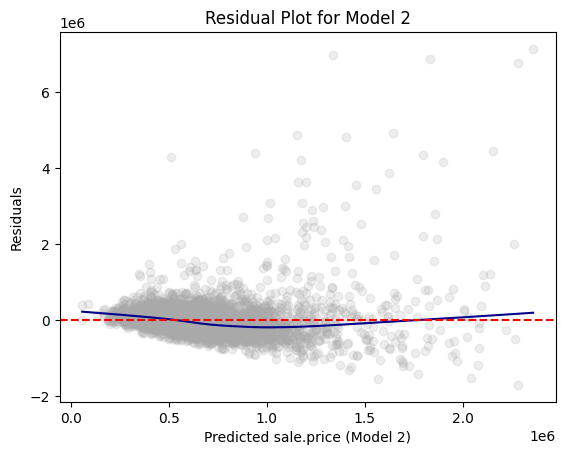

+-------------------------+--------------+------+------------+---------+--------------+--------------+
| Metric                  |        Value | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+-------------------------+--------------+------+------------+---------+--------------+--------------+
| Beta: gross_square_feet |      463.107 | ***  |    192.136 |   0.000 |       86.467 |      839.748 |
| Beta: age               |    2,429.358 | ***  | 20,938.514 |   0.000 |  -38,615.955 |   43,474.670 |
| Intercept               | -216,925.023 | ***  |      9.078 |   0.000 | -216,942.819 | -216,907.227 |
------------------------------------------------------------------------------------------------------
| Observations            |        7,553 |      |            |         |              |              |
| R²                      |        0.263 |      |            |         |              |              |
| RMSE                    |  455,059.540 |      |            |         | 

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm  # for lowess smoothing

plt.scatter(rdf["prediction"], rdf["residual"], alpha=0.2, color="darkgray")

# Use lowess smoothing for the trend line
smoothed = sm.nonparametric.lowess(rdf["residual"], rdf["prediction"])
plt.plot(smoothed[:, 0], smoothed[:, 1], color="darkblue")

# Perfect prediction line
#   A horizontal line at residual = 0
plt.axhline(y=0, color="red", linestyle="--")

# Labeling
plt.xlabel("Predicted sale.price (Model 2)")
plt.ylabel("Residuals")
plt.title("Residual Plot for Model 2")
plt.show()

print(regression_table(model2, assembler2))

# Hypothesis Testing on Beta Coefficient(s)
___

- Goal is to determine whether an IV has a statistically effect on the DV in a lin reg model

* We test whether a specific coefficient βj
 significantly differs from zero:
  * Null Hypothesis (H0): βj=0 (No relationship)
  * Alternative Hypothesis (HA): βj≠0
(Significant relationship)

* The t-statistic is used to test each coefficient:

      - t=βj^−0SE(βj^)

βj^: Estimated coefficient <br>
SE(βj^): Standard error of the estimate

* Will calc p-val based on t-dist with n-k-1 degrees of freedom
* Compare p-value with chosen sig level (α)
  * If p-val <= α: Reject H0 (Significant)
  * If p-val > α: Fail to reject H0 (Not Sig)

* Rejecting H0 means there is sufficient evidence to suggest statistically sig relationsip between IV and DV

# Coefficient Plots in Python

In [ ]:
df_pd = pd.read_csv('https://bcdanl.github.io/data/home_sales_nyc.csv')
sale_df = spark.createDataFrame(df_pd)
sale_df.show()

# 2. Split data into training and testing sets by creating a random column "gp"
sale_df = sale_df.withColumn("gp", rand(seed=123)) # seed is set for replication

# Splits 60-40 into training and test sets
dtrain = sale_df.filter(col("gp") >= 0.4)
dtest = sale_df.filter(col("gp") < 0.4)

# Or simply,
dtrain, dtest = sale_df.randomSplit([0.6, 0.4], seed = 123)



+---------+-------+------------+--------------------+-----------------------+--------+----------+-----------------+----------------+-----------+----------------+-----------------+----------+---------+---+
|sale.date|borough|borough_name|        neighborhood|building_class_category|zip_code|sale_price|residential_units|commercial_units|total_units|land_square_feet|gross_square_feet|year_built|sale_year|age|
+---------+-------+------------+--------------------+-----------------------+--------+----------+-----------------+----------------+-----------+----------------+-----------------+----------+---------+---+
|  8/31/18|      2|       Bronx|CASTLE HILL/UNION...|   01 ONE FAMILY DWE...|   10473|    492525|                1|               0|          1|            2250|             1540|      1960|     2018| 58|
|  8/31/18|      2|       Bronx|           SOUNDVIEW|   01 ONE FAMILY DWE...|   10473|    105000|                1|               0|          1|            3980|             1025| 

In [ ]:
# 0: Bronx, 1: Brooklyn, 2: Manhattan, 3: Queens, 4: Staten Island
dummy_cols, ref_category = add_dummy_variables("borough_name", 2)
# To see dummy variables
dtrain.select(['borough_name'] + dummy_cols).show()
dtrain.select(['borough_name'] + dummy_cols).filter(col('borough_name') == "Manhattan").show()

Reference category (dummy omitted): Manhattan
+------------+------------------+---------------------+-------------------+--------------------------+
|borough_name|borough_name_Bronx|borough_name_Brooklyn|borough_name_Queens|borough_name_Staten_Island|
+------------+------------------+---------------------+-------------------+--------------------------+
|       Bronx|                 1|                    0|                  0|                         0|
|       Bronx|                 1|                    0|                  0|                         0|
|    Brooklyn|                 0|                    1|                  0|                         0|
|    Brooklyn|                 0|                    1|                  0|                         0|
|    Brooklyn|                 0|                    1|                  0|                         0|
|    Brooklyn|                 0|                    1|                  0|                         0|
|    Brooklyn|             

In [ ]:
# Define the list of predictor columns:
# Two numeric predictors plus the dummy variables (excluding the reference dummy)
conti_cols = ["gross_square_feet", "age"]
assembler_predictors = conti_cols + dummy_cols

assembler3 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)
dtrain3 = assembler3.transform(dtrain)
dtest3  = assembler3.transform(dtest)
model3 = LinearRegression(featuresCol="predictors", labelCol="sale_price").fit(dtrain3)
dtest3 = model3.transform(dtest3)

# For model3 and assembler3:
print(regression_table(model3, assembler3))

+----------------------------------+----------------+------+------------+---------+----------------+----------------+
| Metric                           |          Value | Sig. | Std. Error | p-value |   95% CI Lower |   95% CI Upper |
+----------------------------------+----------------+------+------------+---------+----------------+----------------+
| Beta: gross_square_feet          |        391.989 | ***  |    204.243 |   0.000 |         -8.384 |        792.362 |
| Beta: age                        |         -7.449 |      | 75,441.043 |   0.971 |   -147,892.897 |    147,877.998 |
| Beta: borough_name_Bronx         | -3,107,734.887 | ***  | 74,462.161 |   0.000 | -3,253,701.453 | -2,961,768.320 |
| Beta: borough_name_Brooklyn      | -2,659,313.821 | ***  | 74,276.127 |   0.000 | -2,804,915.709 | -2,513,711.933 |
| Beta: borough_name_Queens        | -2,870,994.746 | ***  | 75,420.358 |   0.000 | -3,018,839.645 | -2,723,149.847 |
| Beta: borough_name_Staten_Island | -3,023,379.363 | **

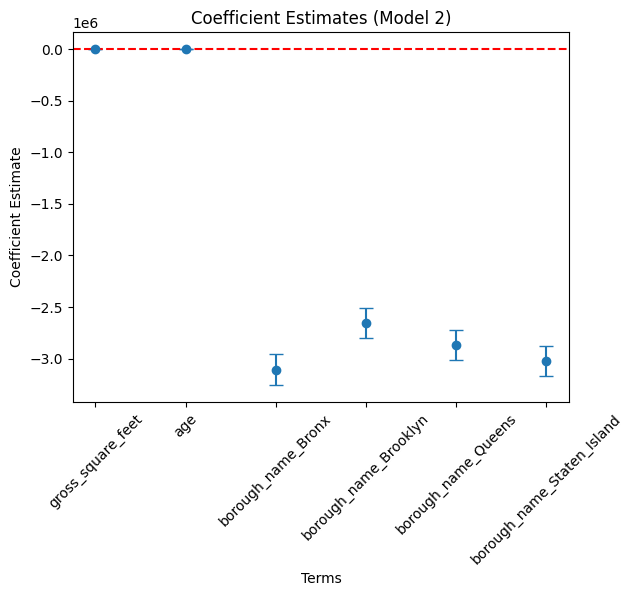

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a Pandas DataFrame from model3's summary information
terms = assembler3.getInputCols()
coefs = model3.coefficients.toArray()[:len(terms)]
stdErrs = model3.summary.coefficientStandardErrors[:len(terms)]

df_summary = pd.DataFrame({
    "term": terms,
    "estimate": coefs,
    "std_error": stdErrs
})

# Plot using the DataFrame columns
plt.errorbar(df_summary["term"], df_summary["estimate"],
             yerr = 1.96 * df_summary["std_error"], fmt='o', capsize=5)
plt.xlabel("Terms")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates (Model 2)")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

# Lin Reg w/ Log Transformation

## Log-transformed Vars in PySpark

In [4]:
from pyspark.sql.functions import log
import numpy
sale_df = sale_df.withColumn("log_sale_price",
                              log( sale_df['sale_price'] ) )
sale_df.show()

+---------+-------+------------+--------------------+-----------------------+--------+----------+-----------------+----------------+-----------+----------------+-----------------+----------+---------+---+------------------+
|sale.date|borough|borough_name|        neighborhood|building_class_category|zip_code|sale_price|residential_units|commercial_units|total_units|land_square_feet|gross_square_feet|year_built|sale_year|age|    log_sale_price|
+---------+-------+------------+--------------------+-----------------------+--------+----------+-----------------+----------------+-----------+----------------+-----------------+----------+---------+---+------------------+
|  8/31/18|      2|       Bronx|CASTLE HILL/UNION...|   01 ONE FAMILY DWE...|   10473|    492525|                1|               0|          1|            2250|             1540|      1960|     2018| 58|13.107300499727284|
|  8/31/18|      2|       Bronx|           SOUNDVIEW|   01 ONE FAMILY DWE...|   10473|    105000|       

# Lin Reg w/ Interaction Terms

* Used to address situations where X1 may vary by X2, where X2 is often a dummy var

* In terms of the nyc df, sale.price may vary by borough name

* Will initialize a new param (for the general example above):
> w1X1 + w2X2 + w3(X1*X2) + b

Example in terms of nyc df:
![](linreg_int.png)


# Classwork 8
___
___

## Q1

In [7]:
bikeshare = pd.read_csv('https://bcdanl.github.io/data/bikeshare_cleaned.csv')
bikeshare = spark.createDataFrame(bikeshare)
bikeshare.show()

+---+----+-----+----+---+--------+-------+-------+--------------------+------------------+-----------------+------------------+
|cnt|year|month|date| hr|   wkday|holiday|seasons|        weather_cond|              temp|              hum|         windspeed|
+---+----+-----+----+---+--------+-------+-------+--------------------+------------------+-----------------+------------------+
| 16|2011|    1|   1|  0|saturday|      0| spring| Clear or Few Cloudy| -1.33460918694128|0.947345243330896|  -1.5538438052971|
| 40|2011|    1|   1|  1|saturday|      0| spring| Clear or Few Cloudy| -1.43847500990342|0.895512927978679|  -1.5538438052971|
| 32|2011|    1|   1|  2|saturday|      0| spring| Clear or Few Cloudy| -1.43847500990342|0.895512927978679|  -1.5538438052971|
| 13|2011|    1|   1|  3|saturday|      0| spring| Clear or Few Cloudy| -1.33460918694128|0.636351351217591|  -1.5538438052971|
|  1|2011|    1|   1|  4|saturday|      0| spring| Clear or Few Cloudy| -1.33460918694128|0.636351351217

In [8]:
bikeshare.describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+---------+--------------------+-------+-------------------+--------------------+--------------------+--------------------+
|summary|              cnt|              year|             month|              date|                hr|    wkday|             holiday|seasons|       weather_cond|                temp|                 hum|           windspeed|
+-------+-----------------+------------------+------------------+------------------+------------------+---------+--------------------+-------+-------------------+--------------------+--------------------+--------------------+
|  count|            17376|             17376|             17376|             17376|             17376|    17376|               17376|  17376|              17376|               17376|               17376|               17376|
|   mean|189.4829650092081| 2011.502532228361| 6.538731583793738|15.682895948434622|11.546731123

In [9]:
(
    bikeshare
    .groupby('holiday')
    .count()
    .show() # Can be done for each var
)

+-------+-----+
|holiday|count|
+-------+-----+
|      0|16876|
|      1|  500|
+-------+-----+



## Q2 - Splitting into test and train sets

In [10]:
bikeshare = bikeshare.withColumn("gp", rand(seed=123)) # seed is set for replication

# Splits 60-40 into training and test sets
dtrain = bikeshare.filter(col("gp") >= 0.4)
dtest = bikeshare.filter(col("gp") < 0.4)

# Or simply,
dtrain, dtest = bikeshare.randomSplit([0.6, 0.4], seed = 123)

## Q3 - Training model and splitting cat --> dummy

In [11]:
def add_dummy_variables(var_name, reference_level, category_order=None):
    """
    Creates dummy variables for the specified column in the global DataFrames dtrain and dtest.
    Allows manual setting of category order.

    Parameters:
        var_name (str): The name of the categorical column (e.g., "borough_name").
        reference_level (int): Index of the category to be used as the reference (dummy omitted).
        category_order (list, optional): List of categories in the desired order. If None, categories are sorted.

    Returns:
        dummy_cols (list): List of dummy column names excluding the reference category.
        ref_category (str): The category chosen as the reference.
    """
    global dtrain, dtest

    # Get distinct categories from the training set.
    categories = dtrain.select(var_name).distinct().rdd.flatMap(lambda x: x).collect()

    # Convert booleans to strings if present.
    categories = [str(c) if isinstance(c, bool) else c for c in categories]

    # Use manual category order if provided; otherwise, sort categories.
    if category_order:
        # Ensure all categories are present in the user-defined order
        missing = set(categories) - set(category_order)
        if missing:
            raise ValueError(f"These categories are missing from your custom order: {missing}")
        categories = category_order
    else:
        categories = sorted(categories)

    # Validate reference_level
    if reference_level < 0 or reference_level >= len(categories):
        raise ValueError(f"reference_level must be between 0 and {len(categories) - 1}")

    # Define the reference category
    ref_category = categories[reference_level]
    print("Reference category (dummy omitted):", ref_category)

    # Create dummy variables for all categories
    for cat in categories:
        dummy_col_name = var_name + "_" + str(cat).replace(" ", "_")
        dtrain = dtrain.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))
        dtest = dtest.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))

    # List of dummy columns, excluding the reference category
    dummy_cols = [var_name + "_" + str(cat).replace(" ", "_") for cat in categories if cat != ref_category]

    return dummy_cols, ref_category


# Example usage without category_order:
# dummy_cols_year, ref_category_year = add_dummy_variables('year', 0)

# Example usage with category_order:
# custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
# dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

In [12]:
import numpy as np
import scipy.stats as stats
from tabulate import tabulate

def regression_table(model, assembler):
    """
    Creates a formatted regression table from a fitted LinearRegression model and its VectorAssembler,
    and inserts a dashed horizontal line after the Intercept row. The table includes separate columns
    for the 95% confidence interval lower and upper bounds for each coefficient (computed at the 5% significance level)
    and an "Observations" row (using model.summary.numInstances) above the R² row.
    The RMSE row is placed as the last row.

    The columns are ordered as:
        Metric | Value | Significance | Std. Error | p-value | 95% CI Lower | 95% CI Upper

    For the "Value", "Std. Error", "95% CI Lower", and "95% CI Upper" columns, commas are inserted every three digits,
    with 3 decimal places (except for Observations which is formatted as an integer with commas).

    Parameters:
        model: A fitted LinearRegression model (with a .summary attribute).
        assembler: The VectorAssembler used to assemble the features for the model.

    Returns:
        A formatted string containing the regression table.
    """
    # Extract coefficients and standard errors as NumPy arrays
    coeffs = model.coefficients.toArray()
    std_errors_all = np.array(model.summary.coefficientStandardErrors)

    # Check if the intercept's standard error is included (one extra element)
    if len(std_errors_all) == len(coeffs) + 1:
        intercept_se = std_errors_all[0]
        std_errors = std_errors_all[1:]
    else:
        intercept_se = None
        std_errors = std_errors_all

    # Compute t-statistics for feature coefficients (t = beta / SE(beta))
    # t_stats = coeffs / std_errors
    t_stats = model.summary.tValues

    # Degrees of freedom: number of instances minus number of predictors minus 1 (for intercept)
    df = model.summary.numInstances - len(coeffs) - 1

    # Compute the t-critical value for a 95% confidence interval (two-tailed, 5% significance)
    t_critical = stats.t.ppf(0.975, df)

    # Compute two-tailed p-values for each feature coefficient
    # p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_stats]
    p_values = model.summary.pValues

    # Function to assign significance stars based on p-value
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Build the table rows.
    # Order: Metric, Value, Significance, Std. Error, p-value, 95% CI Lower, 95% CI Upper.
    table = []
    for feature, beta, se, p in zip(assembler.getInputCols(), coeffs, std_errors, p_values):
        ci_lower = beta - t_critical * se
        ci_upper = beta + t_critical * se
        table.append([
            "Beta: " + feature,       # Metric name
            beta,                     # Beta estimate (Value)
            significance_stars(p),    # Significance stars
            se,                       # Standard error
            p,                        # p-value
            ci_lower,                 # 95% CI lower bound
            ci_upper                  # 95% CI upper bound
        ])

    # Compute and add the intercept row with its SE, p-value, significance, and CI (if available)
    if intercept_se is not None:
        intercept_t = model.intercept / intercept_se
        intercept_p = 2 * (1 - stats.t.cdf(np.abs(intercept_t), df))
        intercept_sig = significance_stars(intercept_p)
        ci_intercept_lower = model.intercept - t_critical * intercept_se
        ci_intercept_upper = model.intercept + t_critical * intercept_se
    else:
        intercept_se = ""
        intercept_p = ""
        intercept_sig = ""
        ci_intercept_lower = ""
        ci_intercept_upper = ""

    table.append([
        "Intercept",
        model.intercept,
        intercept_sig,
        intercept_se,
        intercept_p,
        ci_intercept_lower,
        ci_intercept_upper
    ])

    # Append overall model metrics:
    # Insert an Observations row using model.summary.numInstances,
    # then an R² row, and finally the RMSE row as the last row.
    table.append(["Observations", model.summary.numInstances, "", "", "", "", ""])
    table.append(["R²", model.summary.r2, "", "", "", "", ""])
    table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", ""])

    # Format the table.
    # For the "Value" (index 1), "Std. Error" (index 3), "95% CI Lower" (index 5), and "95% CI Upper" (index 6) columns,
    # format with commas and 3 decimal places, except for Observations which should be an integer with commas.
    # For the p-value (index 4), format to 3 decimal places.
    formatted_table = []
    for row in table:
        formatted_row = []
        for i, item in enumerate(row):
            if row[0] == "Observations" and i == 1 and isinstance(item, (int, float, np.floating)) and item != "":
                # Format Observations as integer with commas, no decimals.
                formatted_row.append(f"{int(item):,}")
            elif isinstance(item, (int, float, np.floating)) and item != "":
                if i in [1, 3, 5, 6]:
                    formatted_row.append(f"{item:,.3f}")
                elif i == 4:
                    formatted_row.append(f"{item:.3f}")
                else:
                    formatted_row.append(f"{item:.3f}")
            else:
                formatted_row.append(item)
        formatted_table.append(formatted_row)

    # Generate the table string using tabulate.
    table_str = tabulate(
        formatted_table,
        headers=["Metric", "Value", "Sig.", "Std. Error", "p-value", "95% CI Lower", "95% CI Upper"],
        tablefmt="pretty",
        colalign=("left", "right", "center", "right", "right", "right", "right")
    )

    # Insert a dashed line after the Intercept row for clarity.
    lines = table_str.split("\n")
    dash_line = '-' * len(lines[0])
    for i, line in enumerate(lines):
        if "Intercept" in line and not line.strip().startswith('+'):
            lines.insert(i+1, dash_line)
            break

    return "\n".join(lines)

# Example usage:
# print(regression_table(lr_model, assembler))

In [13]:
dummy_cols_year, ref_cat_year = add_dummy_variables('year', 0)
dummy_cols_month, ref_cat_month = add_dummy_variables('month', 0)
dummy_cols_hr, ref_cat_hr = add_dummy_variables('hr', 0)
dummy_cols_hol, ref_cat_hol = add_dummy_variables('holiday', 0)
dummy_cols_wc, ref_cat_wc = add_dummy_variables('weather_cond', 0)

custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
dummy_cols_day, ref_cat_day = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

custom_order_season = ['spring', 'summer', 'fall', 'winter']
dummy_cols_season, ref_cat_season = add_dummy_variables('seasons', reference_level=0, category_order = custom_order_season)

cont_cols = ['temp', 'hum', 'windspeed']

features = cont_cols + dummy_cols_year + dummy_cols_month + dummy_cols_hr + dummy_cols_hol + dummy_cols_wc + dummy_cols_day + dummy_cols_season

Reference category (dummy omitted): 2011
Reference category (dummy omitted): 1
Reference category (dummy omitted): 0
Reference category (dummy omitted): 0
Reference category (dummy omitted): Clear or Few Cloudy
Reference category (dummy omitted): sunday
Reference category (dummy omitted): spring


In [14]:
assembler_d = VectorAssembler(
                    inputCols= features,
                    outputCol="predictors")
dtrain2 = assembler_d.transform(dtrain)
dtest2  = assembler_d.transform(dtest)

model_d = LinearRegression(
                featuresCol="predictors",
                labelCol="cnt").fit(dtrain2)
dtest2 = model_d.transform(dtest2)

In [15]:
print(regression_table(model_d, assembler_d))

+---------------------------------------------+---------+------+------------+---------+--------------+--------------+
| Metric                                      |   Value | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+---------------------------------------------+---------+------+------------+---------+--------------+--------------+
| Beta: temp                                  |  42.329 | ***  |      1.396 |   0.000 |       39.592 |       45.066 |
| Beta: hum                                   | -15.818 | ***  |      1.095 |   0.000 |      -17.964 |      -13.673 |
| Beta: windspeed                             |  -4.592 | ***  |      2.033 |   0.000 |       -8.577 |       -0.607 |
| Beta: year_2012                             |  85.733 | ***  |      5.067 |   0.000 |       75.801 |       95.664 |
| Beta: month_2                               |   5.204 |      |      5.702 |   0.304 |       -5.973 |       16.380 |
| Beta: month_3                               |  13.331 

## Q7

In [16]:
feat = assembler_d.getInputCols()
cf = model_d.coefficients.toArray()[:len(feat)]
err = model_d.summary.coefficientStandardErrors[:len(feat)]

df_cw8 = pd.DataFrame({
    'features': feat,
    'est': cf,
    'std_error': err
})

df_cw8

,features,est,std_error
0,temp,42.328840,2.362286
1,hum,-15.818284,1.396342
2,windspeed,-4.591617,1.094665
3,year_2012,85.732784,2.032948
4,month_2,5.203765,5.066519
5,month_3,13.331414,5.701653
6,month_4,6.755455,8.473106
7,month_5,17.228385,9.059851
8,month_6,8.092298,9.320895
9,month_7,-9.132514,10.481312


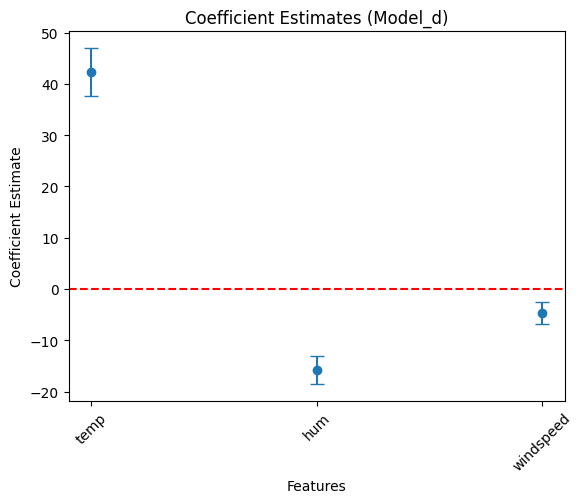

In [18]:
import matplotlib.pyplot as plt

thw = ['temp','hum','windspeed']
df_thw = df_cw8[df_cw8['features'].isin(thw)]

plt.errorbar(df_thw['features'], df_thw['est'],
             yerr = 1.96 * df_thw['std_error'], fmt = 'o', capsize = 5)

plt.xlabel("Features")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates (Model_d)")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

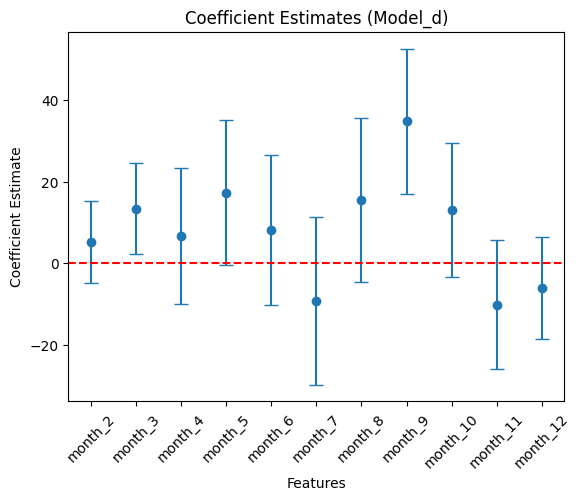

In [19]:
months = []
for i in range(2, 13):
  var = f'month_{i}'
  months.append(var)

df_m = df_cw8[df_cw8['features'].isin(months)]

plt.errorbar(df_m['features'], df_m['est'],
             yerr = 1.96 * df_m['std_error'], fmt = 'o', capsize = 5)

plt.xlabel("Features")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates (Model_d)")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

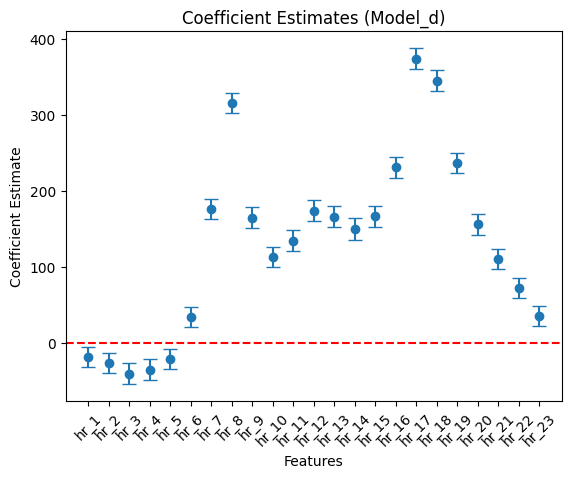

In [20]:
hrs = []

for i in range(1, 24):
  hrs.append(f'hr_{i}')

df_h = df_cw8[df_cw8['features'].isin(hrs)]

plt.errorbar(df_h['features'], df_h['est'],
             yerr = 1.96 * df_h['std_error'], fmt = 'o', capsize = 5)

plt.xlabel("Features")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates (Model_d)")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

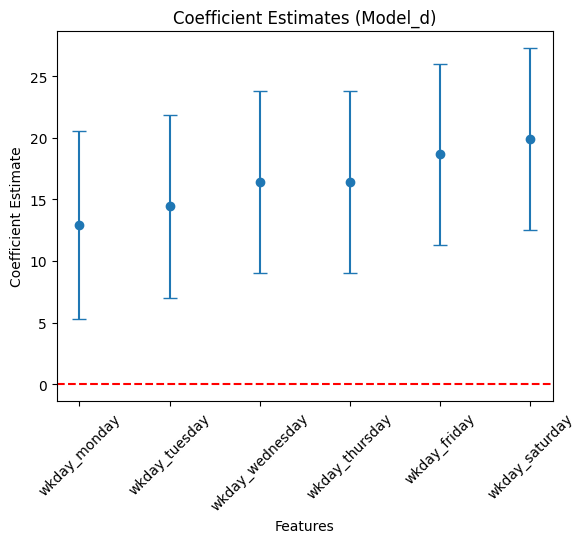

In [21]:
day = ['monday', 'tuesday','wednesday', 'thursday', 'friday', 'saturday']

wkd = []

for i in day:
  wkd.append(f'wkday_{i}')

df_d = df_cw8[df_cw8['features'].isin(wkd)]

plt.errorbar(df_d['features'], df_d['est'],
             yerr = 1.96 * df_d['std_error'], fmt = 'o', capsize = 5)

plt.xlabel("Features")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates (Model_d)")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

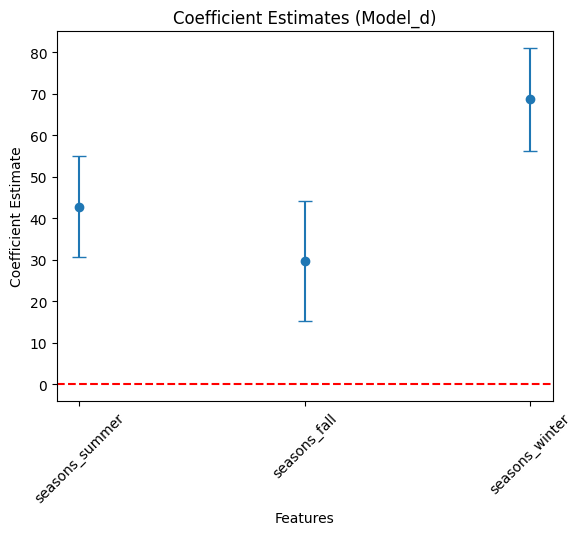

In [22]:
seasons = ['summer', 'fall', 'winter']

sn = []

for i in seasons:
  sn.append(f'seasons_{i}')

df_s = df_cw8[df_cw8['features'].isin(sn)]

plt.errorbar(df_s['features'], df_s['est'],
             yerr = 1.96 * df_s['std_error'], fmt = 'o', capsize = 5)

plt.xlabel("Features")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates (Model_d)")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

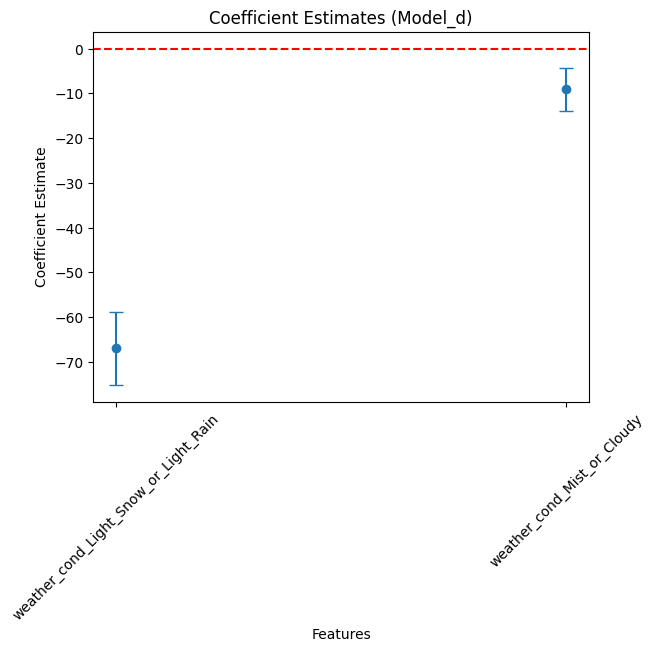

In [23]:
excess = thw + months + hrs + wkd + sn + ['year_2012', 'holiday_1']

df_w = df_cw8[~df_cw8['features'].isin(excess)]

plt.errorbar(df_w['features'], df_w['est'],
             yerr = 1.96 * df_w['std_error'], fmt = 'o', capsize = 5)

plt.xlabel("Features")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates (Model_d)")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

## Q8

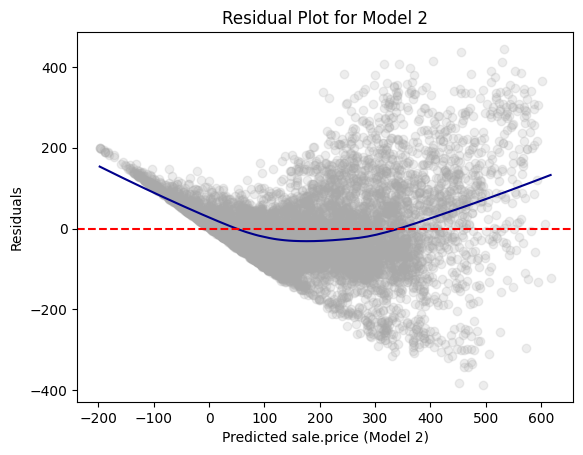

In [24]:
import matplotlib.pyplot as plt
import statsmodels.api as sm  # for lowess smoothing


df = dtest2.select(["prediction", "cnt"]).toPandas()
# Pred and actual following fitting data to model, on test set specifically
df["residual"] = df["cnt"] - df["prediction"]

plt.scatter(df["prediction"], df["residual"], alpha=0.2, color="darkgray")

# Use lowess smoothing for the trend line
smoothed = sm.nonparametric.lowess(df["residual"], df["prediction"])
plt.plot(smoothed[:, 0], smoothed[:, 1], color="darkblue")

# Perfect prediction line
#   A horizontal line at residual = 0
plt.axhline(y=0, color="red", linestyle="--")

# Labeling
plt.xlabel("Predicted sale.price (Model 2)")
plt.ylabel("Residuals")
plt.title("Residual Plot for Model 2")
plt.show()

## Q9

<Axes: xlabel='cnt', ylabel='Count'>

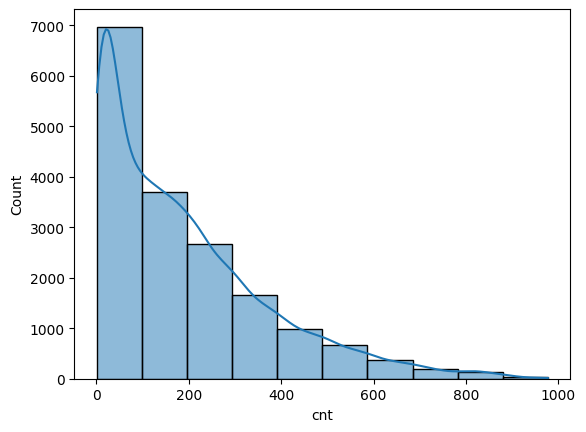

In [25]:
# Create a histogram
import seaborn as sns
dfpd =bikeshare.select(["cnt"]).toPandas()
sns.histplot(dfpd["cnt"], bins=10, kde=True)

<Axes: xlabel='log_cnt', ylabel='Count'>

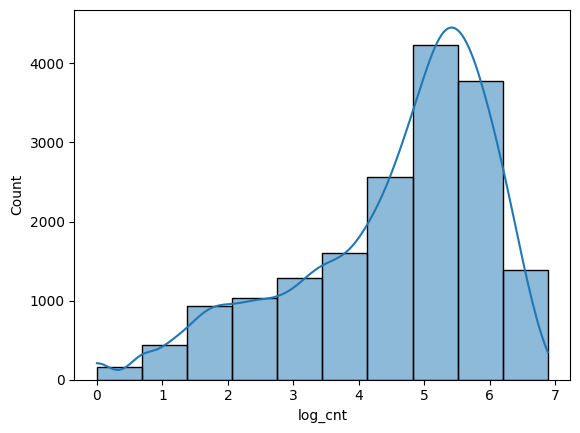

In [26]:
dfpd['log_cnt'] = np.log(dfpd['cnt'])
sns.histplot(dfpd["log_cnt"], bins=10, kde=True)

## Q10

In [36]:
bikeshare = pd.read_csv('https://bcdanl.github.io/data/bikeshare_cleaned.csv')
bikeshare = spark.createDataFrame(bikeshare)
bikeshare.show()

bikeshare = bikeshare.withColumn("log_cnt",
                                 log(bikeshare['cnt']))

bikeshare = bikeshare.withColumn("gp", rand(seed=123)) # seed is set for replication

dtrain, dtest = bikeshare.randomSplit([0.6, 0.4], seed = 123)

dummy_cols_year, ref_cat_year = add_dummy_variables('year', 0)
dummy_cols_month, ref_cat_month = add_dummy_variables('month', 0)
dummy_cols_hr, ref_cat_hr = add_dummy_variables('hr', 0)
dummy_cols_hol, ref_cat_hol = add_dummy_variables('holiday', 0)
dummy_cols_wc, ref_cat_wc = add_dummy_variables('weather_cond', 0)

custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
dummy_cols_day, ref_cat_day = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

custom_order_season = ['spring', 'summer', 'fall', 'winter']
dummy_cols_season, ref_cat_season = add_dummy_variables('seasons', reference_level=0, category_order = custom_order_season)

cont_cols = ['temp', 'hum', 'windspeed']

features = cont_cols + dummy_cols_year + dummy_cols_month + dummy_cols_hr + dummy_cols_hol + dummy_cols_wc + dummy_cols_day + dummy_cols_season

+---+----+-----+----+---+--------+-------+-------+--------------------+------------------+-----------------+------------------+
|cnt|year|month|date| hr|   wkday|holiday|seasons|        weather_cond|              temp|              hum|         windspeed|
+---+----+-----+----+---+--------+-------+-------+--------------------+------------------+-----------------+------------------+
| 16|2011|    1|   1|  0|saturday|      0| spring| Clear or Few Cloudy| -1.33460918694128|0.947345243330896|  -1.5538438052971|
| 40|2011|    1|   1|  1|saturday|      0| spring| Clear or Few Cloudy| -1.43847500990342|0.895512927978679|  -1.5538438052971|
| 32|2011|    1|   1|  2|saturday|      0| spring| Clear or Few Cloudy| -1.43847500990342|0.895512927978679|  -1.5538438052971|
| 13|2011|    1|   1|  3|saturday|      0| spring| Clear or Few Cloudy| -1.33460918694128|0.636351351217591|  -1.5538438052971|
|  1|2011|    1|   1|  4|saturday|      0| spring| Clear or Few Cloudy| -1.33460918694128|0.636351351217

In [37]:
assembler_lg = VectorAssembler(
                    inputCols= features,
                    outputCol="predictors")
dtrainlg = assembler_lg.transform(dtrain)
dtestlg  = assembler_lg.transform(dtest)

model_lg = LinearRegression(
                featuresCol="predictors",
                labelCol="log_cnt").fit(dtrainlg)
dtestlg = model_lg.transform(dtestlg)

print(regression_table(model_lg, assembler_lg))

+---------------------------------------------+--------+------+------------+---------+--------------+--------------+
| Metric                                      |  Value | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+---------------------------------------------+--------+------+------------+---------+--------------+--------------+
| Beta: temp                                  |  0.276 | ***  |      0.009 |   0.000 |        0.259 |        0.292 |
| Beta: hum                                   | -0.048 | ***  |      0.007 |   0.000 |       -0.061 |       -0.035 |
| Beta: windspeed                             | -0.030 | ***  |      0.012 |   0.000 |       -0.054 |       -0.005 |
| Beta: year_2012                             |  0.482 | ***  |      0.031 |   0.000 |        0.421 |        0.543 |
| Beta: month_2                               |  0.126 | ***  |      0.035 |   0.000 |        0.057 |        0.194 |
| Beta: month_3                               |  0.156 | ***  | 